# Neural Architecture Search

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
import json
import os
import pathlib
import shutil

!export TF_CPP_MIN_LOG_LEVEL=3
!export TF_XLA_FLAGS=--tf_xla_enable_xla_devices

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

In [4]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

1 GPU is available.


In [5]:
def load_data(fileIn):
    allFiles = np.loadtxt(fileIn)
    print('total files:' + str(allFiles.shape))
    
    X = allFiles[:, :6].astype('float32')
    y = allFiles[:, 6:].astype('float32')
    
    print(X.shape, y.shape)
    print('MIN: ', X.min(axis=0), y.min(axis=0))
    print('MAX: ', X.max(axis=0), y.max(axis=0))
    
    return X, y

In [6]:
X, y = load_data('data/prop_spec_only.txt')

total files:(1002, 13)
(1002, 6) (1002, 7)
MIN:  [3.7349e-05 6.5130e-02 9.7873e+00 1.2786e+03 5.6994e+02 5.0339e-06] [1.000e-04 0.000e+00 0.000e+00 0.000e+00 1.000e-04 7.027e-01 0.000e+00]
MAX:  [3.7423e-05 6.9571e-02 1.0126e+01 1.2949e+03 5.8160e+02 5.4892e-06] [0.1838 0.09   0.03   0.05   0.1906 0.9405 0.1858]


In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y[:,:], test_size=0.25, random_state=42)

In [8]:
valid_X = test_X
valid_y = test_y

In [9]:
print(f'train_X shape: {np.shape(train_X)}')
print(f'train_y shape: {np.shape(train_y)}')
print(f'valid_X shape: {np.shape(valid_X)}')
print(f'valid_y shape: {np.shape(valid_y)}')
print(f'test_X shape: {np.shape(test_X)}')
print(f'test_y shape: {np.shape(test_y)}')

train_X shape: (751, 6)
train_y shape: (751, 7)
valid_X shape: (251, 6)
valid_y shape: (251, 7)
test_X shape: (251, 6)
test_y shape: (251, 7)


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
# preprocessor_input = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
# preprocessor_input.fit(train_X)
# preprocessor_output = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
# preprocessor_output.fit(train_y)


preprocessor_input = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_input.fit(train_X)
preprocessor_output = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_output.fit(train_y)


X_train = preprocessor_input.transform(train_X)
Y_train = preprocessor_output.transform(train_y)
X_val = preprocessor_input.transform(valid_X)
Y_val = preprocessor_output.transform(valid_y)
X_test = preprocessor_input.transform(test_X)
Y_test = preprocessor_output.transform(test_y)
print(X_train.shape)
print(Y_train.shape)

(751, 6)
(751, 7)


In [12]:
print(X_train.shape)
print(Y_train.shape)

(751, 6)
(751, 7)


In [13]:
train_invalid_indices = np.isnan(X_train).any(axis=1)
val_invalid_indices = np.isnan(X_val).any(axis=1)
test_invalid_indices = np.isnan(X_test).any(axis=1)

In [14]:
X_train = X_train[~train_invalid_indices]
Y_train = Y_train[~train_invalid_indices]
X_val = X_val[~val_invalid_indices]
Y_val = Y_val[~val_invalid_indices]
X_test = X_test[~test_invalid_indices]
Y_test = Y_test[~test_invalid_indices]

In [15]:
import ray

if not(ray.is_initialized()):
    if is_gpu_available:
        ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)            
    else:
        ray.init(num_cpus=2, log_to_driver=False)
        

2022-09-08 23:50:04,897	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265


In [16]:
print(X_train.shape)
print(Y_train.shape)

(751, 6)
(751, 7)


In [17]:
def load_data_test(random_state=42):
    return (X_test, Y_test)

In [18]:
import random
train_idx = random.sample(range(X_train.shape[0]),X_train.shape[0])
val_idx = random.sample(range(X_val.shape[0]),X_val.shape[0])

In [19]:
from sklearn.model_selection import train_test_split

def load_data_train_valid(verbose=0, random_state=42):
    
    #X_train = ray.get(X_train_id)
    #Y_train = ray.get(Y_train_id)
    #X_val = ray.get(X_val_id)
    #Y_val = ray.get(Y_val_id)
    #X_test = ray.get(X_test_id)
    #Y_test = ray.get(Y_test_id)
    
    train_X, valid_X, train_y, valid_y = X_train[train_idx],  X_val[val_idx], Y_train[train_idx], Y_val[val_idx]

    if verbose:
        print(f'train_X shape: {np.shape(train_X)}')
        print(f'train_y shape: {np.shape(train_y)}')
        print(f'valid_X shape: {np.shape(valid_X)}')
        print(f'valid_y shape: {np.shape(valid_y)}')
    return (train_X, train_y), (valid_X, valid_y)



## Define the Neural Architecture Search Space <a class="anchor" id="define-the-neural-architecture-search-space"></a>

The neural architecture search space is composed of discrete decision variables. For each decision variable we choose among a list of possible operation to perform (e.g., fully connected, ReLU). To define this search space, it is necessary to use two classes:

* `KSearchSpace` (for Keras Search Space): represents a directed acyclic graph (DAG) in which each node represents a chosen operation. It represents the possible neural networks that can be created.
* `SpaceFactory`: is a utilitiy class used to pack the logic of a search space definition and share it with others.

Then, inside a `KSearchSpace` we will have two types of nodes:
* `VariableNode`: corresponds to discrete decision variables and are used to define a list of possible operation.
* `ConstantNode`: corresponds to fixed operation in the search space (e.g., input/outputs)

Finally, it is possible to reuse any `tf.keras.layers` to define a `KSearchSpace`. However, it is important to wrap each layer in an `operation` to perform a lazy memory allocation of tensors.

In [20]:

import collections

from deephyper.nas import KSearchSpace

# # Decision variables are represented by nodes in a graph
from deephyper.nas.node import ConstantNode, VariableNode

# # The "operation" creates a wrapper around Keras layers avoid allocating 
# # memory each time a new layer is defined in the search space
# # For Skip/Residual connections we use "Zero", "Connect" and "AddByProjecting"
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity

Dense = operation(tf.keras.layers.Dense)

# Possible activation functions
ACTIVATIONS = [
    tf.keras.activations.elu,
    #tf.keras.activations.gelu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.linear,
    tf.keras.activations.relu,
    tf.keras.activations.selu,
    tf.keras.activations.sigmoid,
    tf.keras.activations.softplus,
    tf.keras.activations.softsign,
    tf.keras.activations.swish,
    tf.keras.activations.tanh,
]

## Define the Evaluator Object

The `Evaluator` object is responsible of defining the backend used to distribute the function evaluation in DeepHyper.

In [21]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback
from deephyper.problem import NaProblem

def get_evaluator(run_function):
    
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        # "callbacks": [TqdmCallback()] # To interactively follow the finished evaluations,
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

For neural architecture search a standard training pipeline is provided by the `run_base_trainer` function from the `deephyper.nas.run` module.

In [22]:
from deephyper.nas.run import run_base_trainer

In [23]:
results = {} # used to store the results of different search algorithms
max_evals = 10 #400 # maximum number of iteratins for all searches

In [24]:
from deephyper.search.nas import RegularizedEvolution

In [25]:
import tensorflow_probability as tfp
# tfd = tfp.distributions

Then, instead of minimising the mean squared error we will minimize the negative log-likelihood baed on the learned probability distribution $p(y|\mathbf{x};\theta)$ where $\theta$ represents a neural network (architecture, training hyperparameters, weights).

In [26]:
class RegressionSpace(KSearchSpace):
    
    def __init__(self, input_shape, output_shape, seed=None, num_layers=3):
        super().__init__(input_shape, output_shape, seed=seed)
        
        self.num_layers = 3
    
    def build(self):

        # After creating a KSearchSpace nodes corresponds to the inputs are directly accessible
        out_sub_graph = self.build_sub_graph(self.input_nodes[0], self.num_layers)

        output = ConstantNode(op=Dense(self.output_shape[0]))  
        self.connect(out_sub_graph, output)

        return self

    def build_sub_graph(self, input_node, num_layers=3):
        

        # Look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([input_node], maxlen=3)
        
        prev_node = input_node
        
        for _ in range(num_layers):
            
            # Create a variable node to list possible "Dense" layers
            dense = VariableNode()
            
            # Add the possible operations to the dense node
            self.add_dense_to_(dense)
            
            # Connect the previous node to the dense node
            self.connect(prev_node, dense)

            # Create a constant node to merge all input connections
            merge = ConstantNode()
            merge.set_op(
                AddByProjecting(self, [dense], activation="relu")
            )

            for node in anchor_points:
                
                # Create a variable node for each possible connection
                skipco = VariableNode()
                
                skipco.add_op(Zero()) # corresponds to no connection
                skipco.add_op(Connect(self, node)) # corresponds to (node => skipco)
                
                # Connect the (skipco => merge)
                self.connect(skipco, merge)

 
            # ! for next iter
            prev_node = merge
            anchor_points.append(prev_node)

        return prev_node

    def add_dense_to_(self, node):
        
        # We add the "Identity" operation to allow the choice "doing nothing"
        node.add_op(Identity())
        
        step = 16
        for units in range(step, step * 16 + 1, step):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))


In [27]:
problem = NaProblem()

problem.load_data(load_data_train_valid)
problem.search_space(RegressionSpace, num_layers=3)

problem.hyperparameters(
    batch_size=problem.add_hyperparameter((2,64), "batch_size"),
    learning_rate=problem.add_hyperparameter((1e-4, 0.1, "log-uniform"), "learning_rate",),
    optimizer=problem.add_hyperparameter(["sgd", "rmsprop", "adagrad", "adam", "adadelta", "adamax", "nadam"], "optimizer",
    ),
    patience_ReduceLROnPlateau=problem.add_hyperparameter(
        (10, 20), "patience_ReduceLROnPlateau"
    ),
    patience_EarlyStopping=problem.add_hyperparameter(
        (20, 30), "patience_EarlyStopping"
    ),
    num_epochs=100,
    callbacks=dict(
        ReduceLROnPlateau=dict(monitor="val_loss", mode="min", verbose=0, patience=5),
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=10),
        # We save trained models in neural architecture search
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        ),
    ),
)

problem.loss('mse')

problem.metrics([])

# The objective is maximized so we take the negative of the validation loss
# where the loss is minimized
problem.objective("-val_loss")

problem

Problem is:
    - search space   : __main__.RegressionSpace
    - data loading   : __main__.load_data_train_valid
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: batch_size, Type: UniformInteger, Range: [2, 64], Default: 33
        * learning_rate: learning_rate, Type: UniformFloat, Range: [0.0001, 0.1], Default: 0.0031622777, on log-scale
        * optimizer: optimizer, Type: Categorical, Choices: {sgd, rmsprop, adagrad, adam, adadelta, adamax, nadam}, Default: sgd
        * patience_ReduceLROnPlateau: patience_ReduceLROnPlateau, Type: UniformInteger, Range: [10, 20], Default: 15
        * patience_EarlyStopping: patience_EarlyStopping, Type: UniformInteger, Range: [20, 30], Default: 25
        * num_epochs: 100
        * callbacks: {'ReduceLROnPlateau': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 5}, 'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 10}, 'ModelCheckpoint': {'monitor': 

In [28]:
from deephyper.search.nas import Random
random_search = Random(problem, get_evaluator(run_base_trainer), log_dir="random_search")
results["random"] = random_search.search(max_evals=max_evals)

/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/deephyper_repo/deephyper/evaluator/_evaluator.py:101: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'num_gpus': 1, 'num_gpus_per_task': 1}


In [29]:
(x, y), (vx, vy) = load_data_train_valid(verbose=1)
(tx , ty) = load_data_test()
s_x = x
s_y = y
s_vx = vx
s_vy = vy

train_X shape: (751, 6)
train_y shape: (751, 7)
valid_X shape: (251, 6)
valid_y shape: (251, 7)


In [30]:
from deephyper.search.nas import AgEBO

# "n_jobs" is the number of processes used to refresh the state of the surrogate model used in AgEBO 
agebo_search = AgEBO(problem, get_evaluator(run_base_trainer), log_dir="agebo_search", n_jobs=7)
results["agebo"] = agebo_search.search(max_evals=max_evals)

Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'num_gpus': 1, 'num_gpus_per_task': 1}


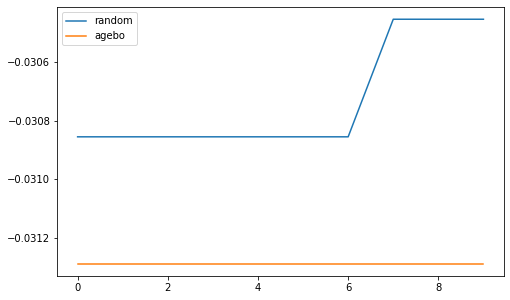

In [31]:
def max_score(l):
    r = [l[0]]
    for el in l[1:]:
        r.append(max(r[-1], el))
    return r

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

for k, result in results.items():
    plt.plot(max_score(results[k].objective), label=k)
    
plt.legend()
    
plt.show()

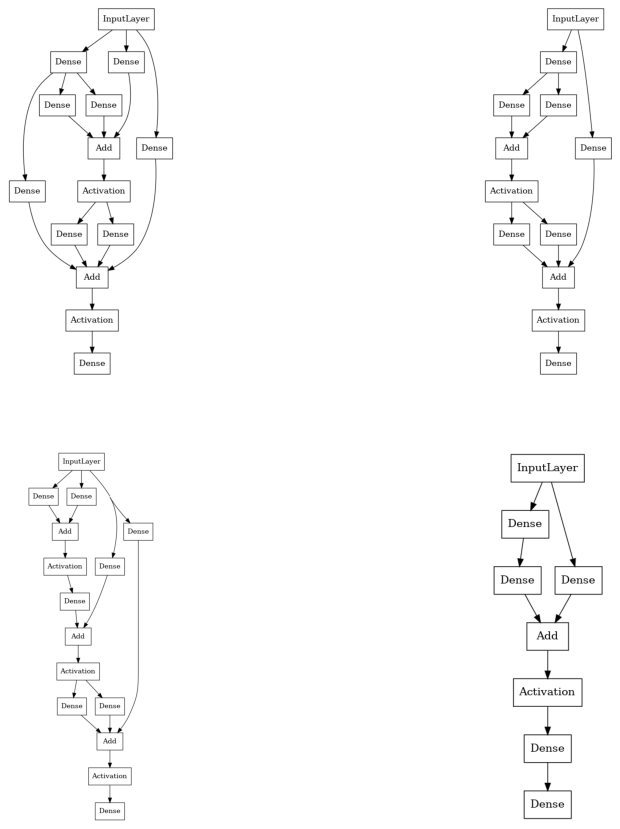

In [32]:
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=(X_train.shape[1],), output_shape=(Y_train.shape[1],))
space = RegressionSpace(**shapes).build()
    

images = []
plt.figure(figsize=(15,15))
for i in range(4):
    
    model = space.sample()
    plt.subplot(2,2,i+1)
    plot_model(model, "random_model.png", show_shapes=False, show_layer_names=False)
    image = mpimg.imread("random_model.png")
    plt.imshow(image)
    plt.axis('off')

plt.show()

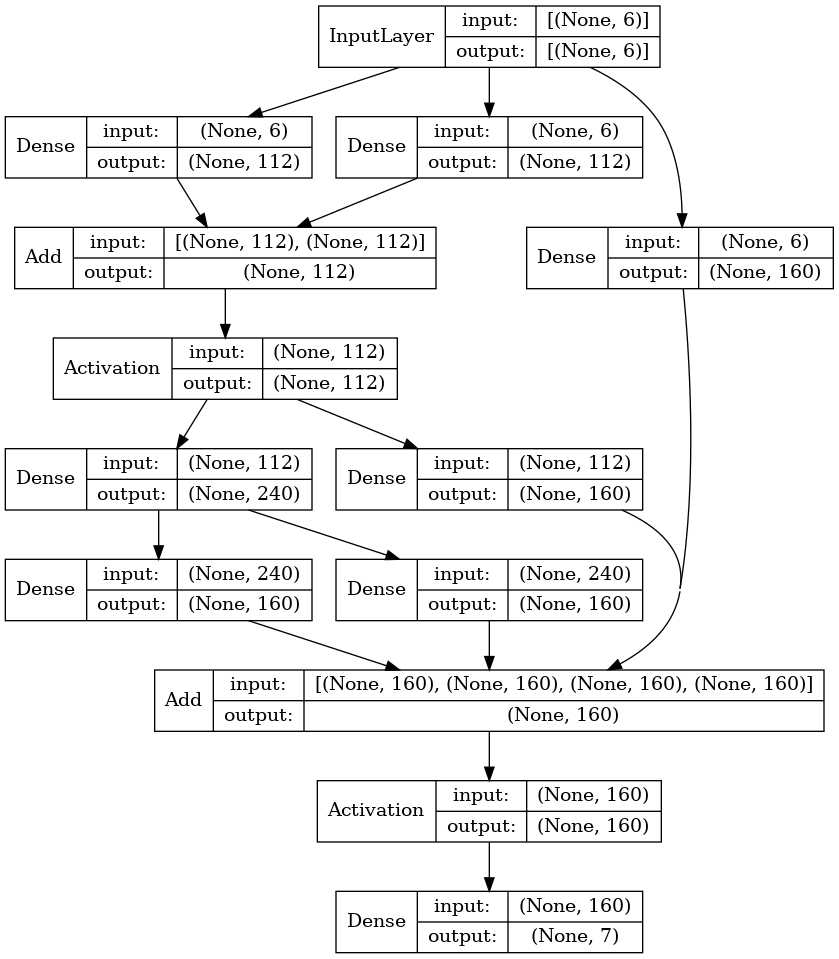

In [33]:
i_max = results["random"].objective.argmax()
best_score = results["random"].iloc[i_max].objective
best_arch_seq = json.loads(results["random"].iloc[i_max].arch_seq)

best_model = space.sample(best_arch_seq)
plot_model(best_model, show_shapes=True, show_layer_names=False)

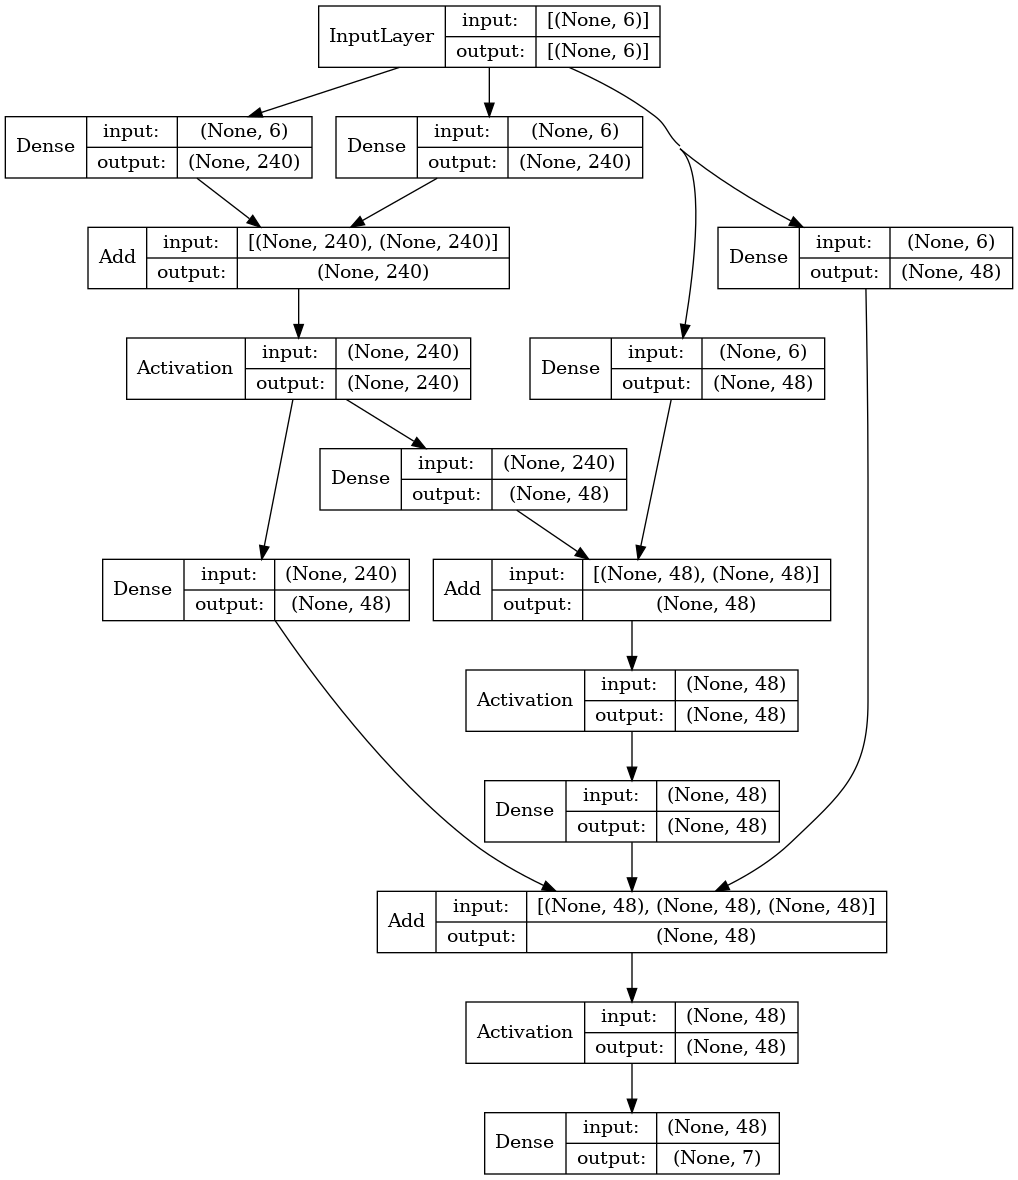

In [42]:
i_max = results["agebo"].objective.argmax()
best_score = results["agebo"].iloc[i_max].objective
best_arch_seq = json.loads(results["agebo"].iloc[i_max].arch_seq)

best_model = space.sample(best_arch_seq)
plot_model(best_model, show_shapes=True, show_layer_names=False)

In [46]:
best_model.compile()

In [51]:
# best_model.compile(
ty = best_model.evaluate(tx)

8/8 [==============================] - 0s 764us/step - loss: 0.0000e+00


In [44]:
# model, history = build_and_train_model(config=best_model.iloc[0], verbose=0) 